# LDA/QDA on height/weight data

We're asked to fit a Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) model to the height/weight data and compute the the misclassification rate. See my implementation of these algorithms on [GitHub](https://github.com/ppham27/MLaPP-solutions/blob/master/chap04/DiscriminantAnalysis.py). The data can be found [here](https://github.com/ppham27/MLaPP-solutions/blob/master/chap04/heightWeightData.txt).

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# benchmark sklearn implementations, these are much faster
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# my own implementation, results are identical but runs much slower
import DiscriminantAnalysis

raw_data = pd.read_csv("heightWeightData.txt", header=None, names=["gender", "height", "weight"])
raw_data.info()
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
gender    210 non-null int64
height    210 non-null int64
weight    210 non-null int64
dtypes: int64(3)
memory usage: 5.0 KB


,gender,height,weight
0,1,67,125
1,2,68,140
2,2,67,142
3,2,60,110
4,2,64,97


Let's plot the data, coloring males blue and females red, too.

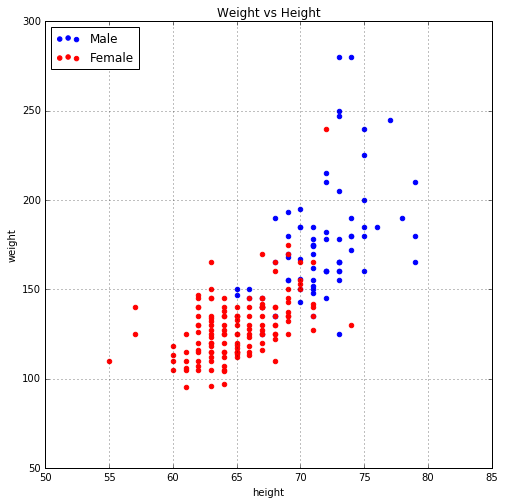

In [2]:
plt.figure(figsize=(8,8))
labels = {1: 'Male', 2: 'Female'}
colors = {1: 'blue', 2: 'red'}
def plot_height_weight(title="Weight vs Height", ax=None):
    if ax == None:
        ax = plt.gca()
    for name, group in raw_data.groupby('gender'):
        ax.scatter(group.height, group.weight, color=colors[name], label=labels[name])
    ax.set_title(title)
    ax.set_xlabel('height')
    ax.set_ylabel('weight')
    ax.legend(loc='upper left')
    ax.grid()
plot_height_weight()
plt.show()

Let's define a few globals to help with the plotting and model fitting.

In [3]:
x_min = 50
x_max = 85
y_min = 50
y_max = 300
X = raw_data[['height', 'weight']].as_matrix()
y = raw_data['gender'].as_matrix()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=200, endpoint=True),
                     np.linspace(y_min, y_max, num=200, endpoint=True))
cmap_light = ListedColormap(['#AAAAFF','#FFAAAA'])
def plot_height_weight_mesh(xx, yy, Z, comment=None, title=None, ax=None):
    if ax == None:
        ax = plt.gca()
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    if title == None:
        plot_height_weight(ax=ax)
    else:
        plot_height_weight(ax=ax, title = title)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    if comment != None:
        ax.text(0.95, 0.05, comment, transform=ax.transAxes,
                verticalalignment="bottom", horizontalalignment="right",
                fontsize=14)
def decimal_to_percent(x, decimals=2):
    return '{0:.2f}%'.format(np.round(100*x, decimals=2))

Let's try the QDA model first. We follow the conventions of the `sklearn` implementation. Let $X$ be our data or design matrix and $y$ be our class label. The rows of $X$ consist of the vectors $\mathbf{x}_i$, which are the individual observations. We let $y_i \sim \mathrm{Multinomial}\left(\theta_1,\ldots,\theta_K\right)$, where $\sum_{k=1}^K \theta_k = 1$. We let $\mathbf{x}_i \mid y_i = k \sim \mathcal{N}\left(\mathbf{\mu}_k, \Sigma_k\right)$, which is a multivariate normal. We use the following estimates for the parameters:

\begin{align}
\hat{\theta}_k &= \frac{N_k}{N} \\
\hat{\mu}_k &= \frac{1}{N_k}\sum_{\{i~:~ y_i = k\}}\mathbf{x}_i \\
\hat{\Sigma}_k &= \frac{1}{N_k - 1}\sum_{\{i~:~y_i = k\}} \left(\mathbf{x}_i - \hat{\mu}_k\right)\left(\mathbf{x}_i - \hat{\mu}_k\right)^\intercal.
\end{align}

$N$ is total number of observations, and $N_k$ is the number of observations of class $k$. Thus, for each class $k$, we compute the proportion of observations that are of that class, the sample mean, and the unbiased estimate for covariance.

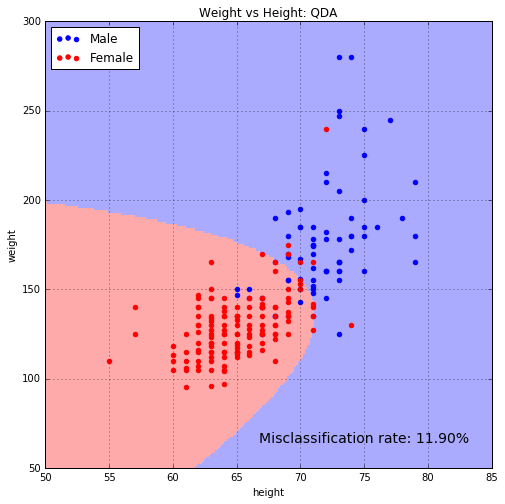

In [4]:
# qda = QuadraticDiscriminantAnalysis(store_covariances=True) # sklearn implementation
qda = DiscriminantAnalysis.QDA() # my implementation
qda.fit(X, y)
qda_misclassification = 1 - qda.score(X, y)
qda_Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
qda_Z = qda_Z.reshape(xx.shape)
plt.figure(figsize=(8,8))
plot_height_weight_mesh(xx, yy, qda_Z, title="Weight vs Height: QDA",
                        comment="Misclassification rate: " + decimal_to_percent(qda_misclassification))
plt.show()

Let's look at LDA now. We compute $\hat{\theta}_k$ and $\hat{\mu}_k$ in the same manner. However, now we have that all covariances are equal, that is, $\hat{\Sigma} = \hat{\Sigma}_k$ for all $k$. Let $p$ be the number of features, that is, the number of columns in $X$. First, we note that

\begin{align}
\log p\left(\mathcal{D} \mid \boldsymbol\mu, \Sigma,\boldsymbol\theta\right)
&= \sum_{i=1}^N \log p\left(\mathbf{x}_i,y_i \mid \boldsymbol\mu, \Sigma,\boldsymbol\theta\right)
= \sum_{k = 1}^K \sum_{\{i~:~y_i = k\}} \log p\left(\mathbf{x}_i, y_i = k \mid \mu_k, \Sigma, \theta_k\right) \\
&= \sum_{k = 1}^K \sum_{\{i~:~y_i = k\}} \left[\log p(y_i = k) + \log p\left(\mathbf{x}_i \mid \mu_k, \Sigma, y_i=k\right)\right] \\
&= \sum_{k = 1}^K \sum_{\{i~:~y_i = k\}} \left[\log \theta_k - \frac{p}{2}\log 2\pi - \frac{1}{2}\log|\Sigma|
- \frac{1}{2}\left(\mathbf{x}_i - \mu_k\right)^\intercal\Sigma^{-1}\left(\mathbf{x}_i - \mu_k\right)\right] \\
&= -\frac{Np}{2}\log 2\pi -\frac{N}{2}\log|\Sigma| + \sum_{k = 1}^K \left(N_k\log\theta_k - \frac{1}{2}\sum_{\{i~:~y_i = k\}}\left(\mathbf{x}_i - \mu_k\right)^\intercal\Sigma^{-1}\left(\mathbf{x}_i - \mu_k\right)\right).
\end{align}

Let $\Lambda = \Sigma^{-1}$. The MLE is invariant with regard to reparameterization, so after isolating the terms that involve $\Sigma$ we can focus on maximizing

\begin{align}
l(\Lambda) &= \frac{N}{2}\log|\Lambda| - \frac{1}{2}\sum_{k = 1}^K \sum_{\{i~:~y_i = k\}}\left(\mathbf{x}_i - \mu_k\right)^\intercal\Lambda\left(\mathbf{x}_i - \mu_k\right) \\
&= \frac{N}{2}\log|\Lambda| - \frac{1}{2}\sum_{k = 1}^K \sum_{\{i~:~y_i = k\}}\operatorname{tr}\left(\left(\mathbf{x}_i - \mu_k\right)\left(\mathbf{x}_i - \mu_k\right)^\intercal\Lambda\right),
\end{align}

where we have used the fact that $\left(\mathbf{x}_i - \mu_k\right)^\intercal\Sigma^{-1}\left(\mathbf{x}_i - \mu_k\right)$ is a scalar, so we can replace it with the trace, and then, we apply the fact that the trace remains the same after cyclic permutations.

Now, we note these two identities to help us take the derivative with respect to $\Lambda$,

\begin{align}
\frac{\partial}{\partial\Lambda}\log|\Lambda| &= \left(\Lambda^{-1}\right)^\intercal \\
\frac{\partial}{\partial\Lambda}\operatorname{tr}\left(A\Lambda\right) &= A^\intercal.
\end{align}

Thus, we'll have that

\begin{align}
l^\prime(\Lambda) &= \frac{N}{2}\left(\Lambda^{-1}\right)^\intercal - \frac{1}{2}\sum_{k=1}^K\left(\sum_{\{i~:~y_i = k\}}\left(\mathbf{x}_i - \mu_k\right)\left(\mathbf{x}_i - \mu_k\right)^\intercal\right) \\
&= \frac{N}{2}\Sigma - \frac{1}{2}\sum_{k=1}^K\left(\sum_{\{i~:~y_i = k\}}\left(\mathbf{x}_i - \mu_k\right)\left(\mathbf{x}_i - \mu_k\right)^\intercal\right)
\end{align}

since $\Lambda^{-1} = \Sigma$ and $\Sigma$ is symmetric.

Setting $l^\prime(\Lambda) = 0$ and solving for $\Sigma$, we have that

\begin{equation}
\Sigma = \frac{1}{N} \sum_{k=1}^K\left(\sum_{\{i~:~y_i = k\}}\left(\mathbf{x}_i - \mu_k\right)\left(\mathbf{x}_i - \mu_k\right)^\intercal\right).
\end{equation}

In this manner our estimate is

\begin{equation}
\hat{\Sigma} = \frac{1}{N} \sum_{k=1}^K\left(\sum_{\{i~:~y_i = k\}}\left(\mathbf{x}_i - \hat{\mu}_k\right)\left(\mathbf{x}_i - \hat{\mu}_k\right)^\intercal\right).
\end{equation}

For whatever reason, `sklearn` uses the biased MLE estimate for covariance in LDA, but it uses the unbiased estimate for covariance in QDA.

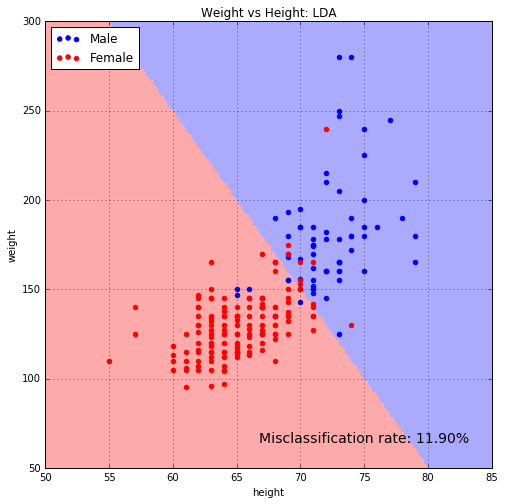

In [5]:
# lda = LinearDiscriminantAnalysis(store_covariance=True) # sklearn implementation
lda = DiscriminantAnalysis.LDA() # my implementation
lda.fit(X, y)
lda_misclassification = 1 - lda.score(X, y)
lda_Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
lda_Z = lda_Z.reshape(xx.shape)
plt.figure(figsize=(8,8))
plot_height_weight_mesh(xx, yy, lda_Z, title="Weight vs Height: LDA",
                        comment="Misclassification rate: " + decimal_to_percent(lda_misclassification))
plt.show()

Clearly, we see that the two methods give us different decision boundaries. However, for these data, the misclassification rate is the same.

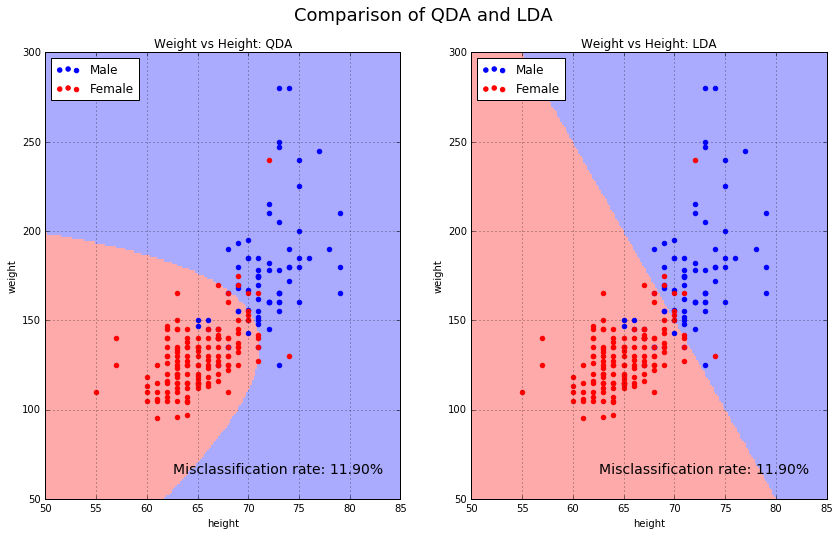

In [6]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
plot_height_weight_mesh(xx, yy, qda_Z, title="Weight vs Height: QDA", ax=ax1,
                        comment="Misclassification rate: " + decimal_to_percent(qda_misclassification))
plot_height_weight_mesh(xx, yy, lda_Z, title="Weight vs Height: LDA", ax=ax2,
                        comment="Misclassification rate: " + decimal_to_percent(lda_misclassification))
fig.suptitle('Comparison of QDA and LDA', fontsize=18)
plt.show()